# TODO:
### DQN on cartpole 
- [x] Read about DQN and plan classes
- [ ] Test for dtypes, shapes, correct gradient changes, everything is a tensor, tests for making sure no_grad is on in the right points
- [ ] Assert optimiser has zero grad just before it calculates the gradients
- [ ] Make sure every input to a network is a tensor, and every input to a gym env is of right type and shape

#### Questions/cheat sheet
- When do i stop the gradients? Only have gradients when computing the loss for an update. 
    - Compute gradients for calculating things which have used the weights which need updating. 
    - I don't want requires_grad for environment outputs, only weights/params in the learnable nets
- Do the dimensions of inputs to network have to include batch size, even if it is always 1?  I think so. Whenever an input goes into a network basically.
- How do i pass a gradient through a distribution
    - Using rdist
- Convert everything that needs to go into a network to a tensor, float, device, has to have 0th dim as batch size when input for a net
    - Dtype is float for everything since tensors are only used to go in the network. 
    - So the dtype only matters in the networks, and float is safe for passing through networks.
- Use `.gather()` for getting the Q values as it is differentiable 
- Do i need to do a deepcopy of all transitions when sampling from buffer? 
    - No because I convert them to a tensor anyway which produces a new memory and reference
- Only need to transfer to device when I when I create a new tensor or model that you want the parameters to be on cuda. 
    - So model has params (weights) so it is on cuda, most loss functions are not on cuda, any inputs and outputs to something on cuda are on cuda, so states etc, inputs etc have to be on cuda.

In [1]:
import gym
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import deque
from gym.spaces.box import Box
from typing import List, Tuple
from deeprl.common.utils import get_gym_space_shape, net_gym_space_dims
from torch.distributions import Categorical
from deeprl.common.base import *
from deeprl.common.utils import *
from deeprl.algos.a2c.a2c import A2C

In [2]:
ENVNAME = 'LunarLander-v2'
env = gym.make(ENVNAME)
# env2 = gym.make('BipedalWalker-v3')

In [3]:
des = [
    (nn.Linear, {"in_features":net_gym_space_dims(env.observation_space), "out_features":128}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features":128, "out_features": 64}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features":64, "out_features": net_gym_space_dims(env.action_space)})
]

In [4]:
Network(des)

Network(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [5]:
state = env.reset()
state = torch.from_numpy(state).unsqueeze(0)
policy = CategoricalPolicy(des)
a = policy.get_action(state)
lp = policy.get_log_prob(state, a)
ent = policy.get_entropy(state)

assert env.action_space.contains(a.cpu().detach().squeeze().numpy())
assert type(lp) == torch.Tensor
assert lp.dtype == torch.float
assert lp.requires_grad
assert lp.shape == (1,)

assert type(ent) == torch.Tensor
assert ent.dtype == torch.float
assert ent.requires_grad
assert ent.shape == (1,)


In [6]:
state = env.reset()
states = torch.stack([torch.from_numpy(state.astype(np.float32)).to('cpu') for _ in range(10)])
policy = CategoricalPolicy(des)
a = policy.get_action(states)
lp = policy.get_log_prob(states, a)
ent = policy.get_entropy(states)


In [7]:
print(a.shape, lp.shape, ent.shape)

torch.Size([10]) torch.Size([10]) torch.Size([10])


In [22]:
env = gym.make("CartPole-v1")
policy_layers = [
    (nn.Linear,
        {"in_features": net_gym_space_dims(env.observation_space),
        "out_features": 20}),
    (nn.ReLU, {}),
    (nn.Linear,
        {"in_features": 20,
        "out_features": 20}),
    (nn.ReLU, {}),
    (nn.Linear,{"in_features": 20, "out_features": net_gym_space_dims(env.action_space)}),
]

critic_layers = [
    (nn.Linear, {"in_features": net_gym_space_dims(env.observation_space), "out_features": 20}),
    (nn.ReLU, {}),
    (nn.Linear,
        {"in_features": 20,
        "out_features": 20}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features": 20, "out_features": 1}),
]

a2c_args = {
    "gamma": 0.99,
    "env": env,
    "step_lim": 200,
    "policy": CategoricalPolicy(policy_layers),
    "policy_optimiser": optim.Adam,
    "policy_lr": 0.002,
    "critic": Network(critic_layers),
    "critic_lr": 0.002,
    "critic_optimiser": optim.Adam,
    "critic_criterion": nn.MSELoss(),
    "device": "cpu",
    "entropy_coef": 0.01,
    "batch_size": 256,
    "num_train_passes": 1,
    "lam": 0.95,
    "num_eval_episodes": 15
}


In [23]:
agent = A2C(a2c_args)
s = env.reset()
for _ in range(200):
    a = agent.choose_action(s)
    assert env.action_space.contains(a)
    assert lp.requires_grad
    assert ent.requires_grad
    s_, r, d, _ = env.step(a)
    if d:
        s = env.reset()
    else:
        s = s_

In [24]:
agent=A2C(a2c_args)

In [25]:
out = agent.run_experiment(350)

After epoch 0, policy loss=-0.0040985699743032455, critic loss=67.07164764404297, average reward earned=22.8
After epoch 1, policy loss=-0.007245211862027645, critic loss=89.46859741210938, average reward earned=19.133333333333333
After epoch 2, policy loss=-0.008902182802557945, critic loss=71.02564239501953, average reward earned=22.533333333333335
After epoch 3, policy loss=-0.00633203936740756, critic loss=80.87264251708984, average reward earned=23.2
After epoch 4, policy loss=-0.008748108521103859, critic loss=81.6391830444336, average reward earned=21.666666666666668
After epoch 5, policy loss=-0.008066423237323761, critic loss=77.19857788085938, average reward earned=18.0
After epoch 6, policy loss=-0.006685704458504915, critic loss=112.27532196044922, average reward earned=20.266666666666666
After epoch 7, policy loss=-0.008351532742381096, critic loss=90.02171325683594, average reward earned=17.6
After epoch 8, policy loss=-0.008896386250853539, critic loss=72.96662902832031,

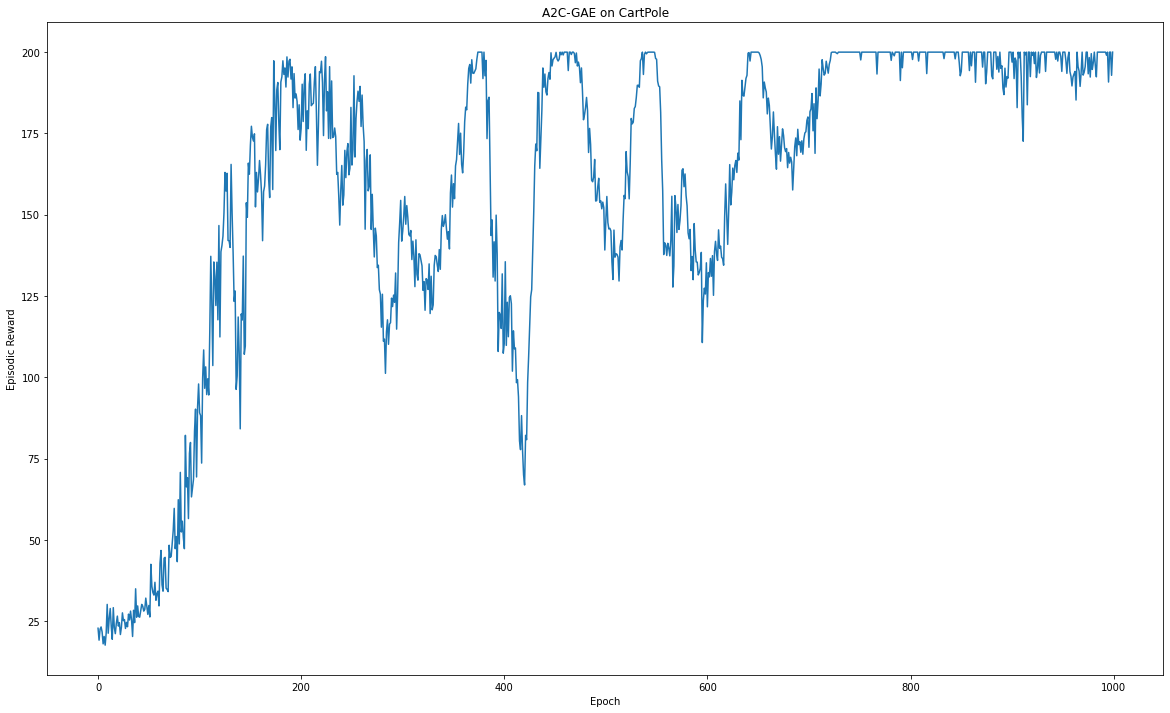

In [26]:
plt.figure(figsize=(20,12))
plt.title('A2C-GAE on CartPole')
plt.xlabel('Epoch')
plt.ylabel('Episodic Reward')
plt.plot(out[-1])
# plt.legend()

plt.savefig('./data/a2c_gae_cartpole_learning_curve.PNG')
plt.show()



In [83]:
num_agents = 5
num_epi = 200
r = []

for i in range(num_agents):
    print("Running training for agent number {}".format(i))
    agent = A2C(a2c_args)
        
    # random.seed(i)
    # np.random.seed(i)
    # torch.manual_seed(i)
    # env.seed(i)

    r.append(agent.train(num_epi))

out = np.array(r).mean(0)

plt.figure(figsize=(5, 3))
plt.title('A2C on cartpole')
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.plot(out, label='rewards')
plt.legend()

# plt.savefig('./data/a2c_cartpole.PNG')
plt.show()

Running training for agent number 0


AttributeError: 'A2C' object has no attribute 'train'